In [199]:
import os
import contextily as ctx
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import sqrt
from sklearn.base import clone
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import SelectFromModel

# Linear regression

## Load data

In [200]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}_ahn_elevation.csv")
df = pd.read_csv(path)
len(df)

7620

In [201]:
df.columns

Index(['bro-id', 'nitrate', 'geometry', 'date', 'landuse code', 'soil region',
       'population', 'elevation', 'lon', 'lat', 'precipitation', 'temperature',
       'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1',
       'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1',
       'cnratio_1', 'peattype_1', 'calciccontent_1', 'fedith_1',
       'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1',
       'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1',
       'siltcontent_1', 'groundwater_depth'],
      dtype='object')

In [202]:
# df = df[df["soil region"] != "veen"]
# len(df)

## Sort by date

In [203]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove some columns and rows

--> By dropping Nan we exclude nitrate points that fall under city areas

In [204]:
df = df.drop(columns=['soil region', 'peattype_1'])
# df = df.drop(columns=['landuse code'])

df = df.dropna()
len(df)

5341

## Add month and year as a feature

In [205]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Change column type

In [206]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

## Remove nitrate outliers

<Axes: >

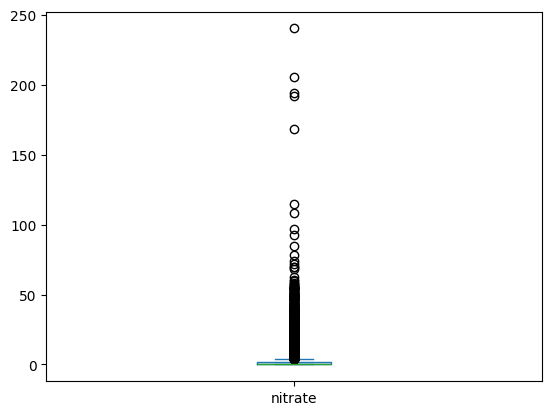

In [207]:
df[["nitrate"]].plot(kind = "box")

In [208]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
# outliers

Outliers found: 1069


In [209]:
top_nitrate_outliers = list(df["nitrate"].sort_values()[-20:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

5321

## Test / train split

In [210]:
# Define the split by year
train_years = list(range(2008, 2021))
test_years = [2021, 2022, 2023]

# Filter datasets
train_df = df[df["year"].isin(train_years)].copy()
test_df = df[df["year"].isin(test_years)].copy()

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 4439
Test: 882


In [211]:
# n = len(df)
# train_size = int(n * 0.8)

# train_df = df.iloc[:train_size]
# test_df = df.iloc[train_size:]

# print(f"Train: {len(train_df)}")
# print(f"Test: {len(test_df)}")


In [212]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [213]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [214]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['landuse code', 'mainsoilclassification_1']
Numerical: ['population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1', 'cnratio_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1', 'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1', 'siltcontent_1', 'groundwater_depth']
All X_train columns: ['landuse code', 'population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1', 'cnratio_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1', 'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1', 'siltcontent_1', 'groundwater_depth']


In [215]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [216]:
lr_model = Ridge()

In [217]:
# Define feature selector using Ridge
number_of_features = 20  # not directly usable, but you can use threshold instead
ridge_selector = Ridge(alpha=1.0, random_state=123)  # you can tune alpha

selector = SelectFromModel(
    ridge_selector,
    threshold=-np.inf,  # initially keep all features
    max_features=number_of_features,
)

In [218]:
# pipe = Pipeline([
#     ("prep", preprocessor),
#     # ("selector", selector),
#     ("lr", lr_model)
# ])

# full_pipeline = TransformedTargetRegressor(
#     regressor=pipe,
#     func=np.log1p,
#     inverse_func=np.expm1
# )




ridge_selector = Ridge(random_state=123)

pipe = Pipeline([
    ("prep", preprocessor),
    ("selector", SelectFromModel(ridge_selector)),
    ("lr", Ridge())
])

# Transformed regressor
full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    # func=np.log1p,
    # inverse_func=np.expm1
)

In [219]:
# Alpha grid (logarithmic scale)
alphas = np.logspace(-4, 4, 50)
# alphas = np.logspace(-3, 1, 10)

# Time series split
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with time series CV
# param_grid = {
#     "regressor__lr__alpha": alphas
# }

param_grid = {
    "regressor__selector__estimator__alpha": [0.1, 1.0, 10.0],
    "regressor__selector__max_features": [10, 20, 40],
    "regressor__lr__alpha": [0.1, 1.0, 10.0]
}

grid = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    scoring="r2",  # or "neg_root_mean_squared_error"
    cv=tscv,
    n_jobs=-1,
    verbose=1
)


## Train model

In [220]:
# Fit
grid.fit(X_train, y_train)

# Best model and alpha
best_model = grid.best_estimator_
print("Best alpha:", grid.best_params_["regressor__lr__alpha"])
print("Best CV MAE:", grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best alpha: 10.0
Best CV MAE: 0.20353030407242462


## Learning curve

In [221]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [222]:
n = len(X_train)

train_errors = []
val_errors = []
train_stds = []
val_stds = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=7)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        y_tr_pred = np.clip(y_tr_pred, 0, 10)
        y_val_pred = np.clip(y_val_pred, 0, 10)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    # Store mean and std
    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))
    train_stds.append(np.std(fold_train_scores))
    val_stds.append(np.std(fold_val_scores))

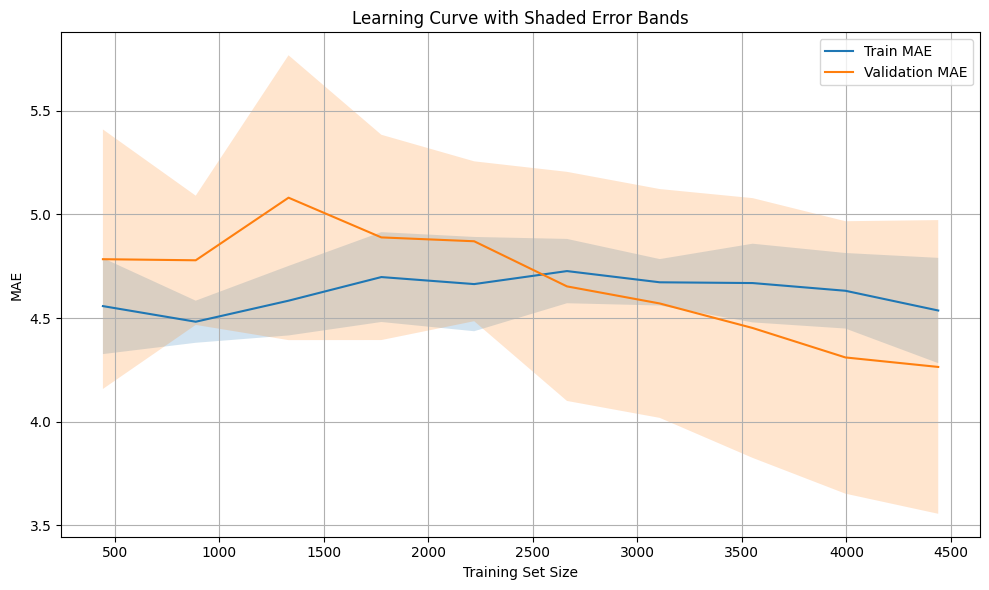

In [223]:
# X-axis
train_sizes_abs = train_sizes * len(X_train)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_errors, label="Train MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2)

plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Learning Curve with Shaded Error Bands")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

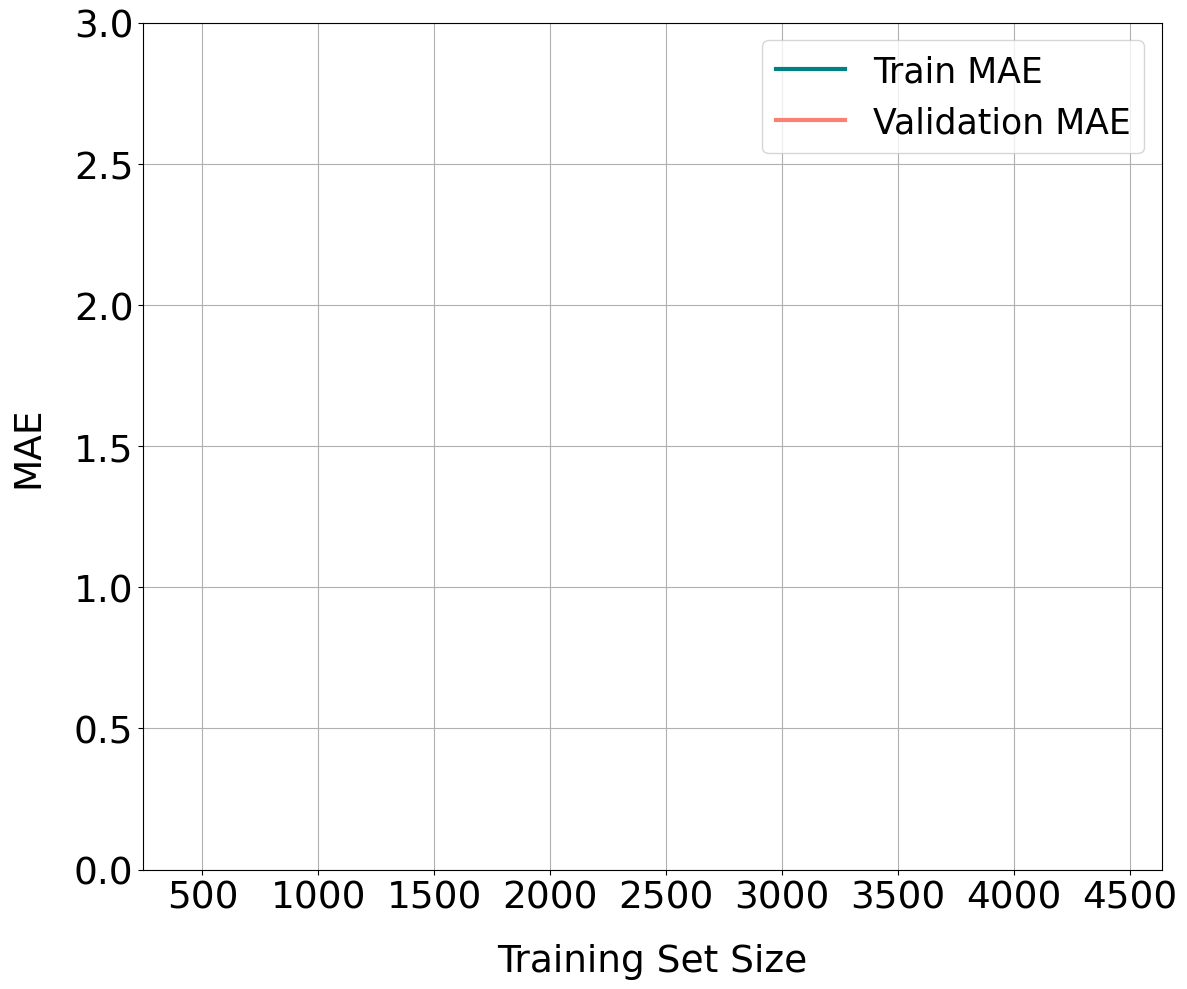

In [224]:
import matplotlib.pyplot as plt

train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(12, 10))

# Plot lines with custom colors
plt.plot(train_sizes_abs, train_errors, label="Train MAE", color="teal", linewidth=3)  
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2, color="teal")

plt.plot(train_sizes_abs, val_errors, label="Validation MAE", color="salmon", linewidth=3)
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2, color="salmon")

# Increase font sizes
plt.xlabel("Training Set Size", fontsize=27, labelpad=20)
plt.ylabel("MAE", fontsize=27, labelpad=20)
# plt.title("Learning Curve (Random Forest)", fontsize=16)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=25)
plt.ylim(0, 3)  # Set fixed y-axis range
plt.grid(True)
plt.tight_layout()
plt.show()

In [225]:
# from sklearn.linear_model import Ridge

# # Use optimal alpha from grid search
# best_alpha = grid.best_params_["regressor__lr__alpha"]

# ridge = Ridge(alpha=best_alpha)
# model = Pipeline([
#     ("prep", preprocessor),
#     ("ridge", ridge)
# ])

# train_errors = []
# val_errors = []
# train_stds = []
# val_stds = []

# train_sizes = np.linspace(0.1, 1.0, 10)
# n = len(X_train)

# for frac in train_sizes:
#     split_idx = int(frac * n)
#     X_subset = X_train.iloc[:split_idx]
#     y_subset = y_train.iloc[:split_idx]

#     tscv = TimeSeriesSplit(n_splits=5)
#     fold_train_scores = []
#     fold_val_scores = []

#     for train_idx, val_idx in tscv.split(X_subset):
#         X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
#         y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

#         # Manual log-transform
#         y_tr_log = np.log1p(y_tr)
#         y_val_log = np.log1p(y_val)

#         model.fit(X_tr, y_tr_log)

#         y_tr_pred = model.predict(X_tr)
#         y_val_pred = model.predict(X_val)

#         # Clip to avoid np.expm1 overflow
#         y_tr_pred = np.clip(y_tr_pred, -10, 10)
#         y_val_pred = np.clip(y_val_pred, -10, 10)

#         # Inverse transform
#         y_tr_pred_orig = np.expm1(y_tr_pred)
#         y_val_pred_orig = np.expm1(y_val_pred)
#         y_tr_orig = np.expm1(y_tr_log)
#         y_val_orig = np.expm1(y_val_log)

#         fold_train_scores.append(mean_absolute_error(y_tr_orig, y_tr_pred_orig))
#         fold_val_scores.append(mean_absolute_error(y_val_orig, y_val_pred_orig))

#     train_errors.append(np.mean(fold_train_scores))
#     val_errors.append(np.mean(fold_val_scores))
#     train_stds.append(np.std(fold_train_scores))
#     val_stds.append(np.std(fold_val_scores))

# # Plotting
# train_sizes_abs = train_sizes * len(X_train)

# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes_abs, train_errors, label="Train MAE")
# plt.fill_between(train_sizes_abs,
#                  np.array(train_errors) - np.array(train_stds),
#                  np.array(train_errors) + np.array(train_stds),
#                  alpha=0.2)

# plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
# plt.fill_between(train_sizes_abs,
#                  np.array(val_errors) - np.array(val_stds),
#                  np.array(val_errors) + np.array(val_stds),
#                  alpha=0.2)

# plt.xlabel("Training Set Size")
# plt.ylabel("MAE")
# plt.title("Learning Curve with Shaded Error Bands (Ridge)")
# plt.legend()
# plt.ylim(0, 3)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

## Train model

In [226]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        '...
                                                                                        'minimumacidity_1',
                                                                                        'maximumacidity_1',
                                                                                        'cnratio_1',
                                                                                        'calciccontent_1',
                                                                                        'fedith_1',
                                                                                        'loamcontent_1',
                                                                                        'minimumloamcontent_1',
                                                                                        'maximumloamcontent_1',
                                                                                        'sandmedian_1',
                                                                                        'minimumsandmedian_1',
                                                                                        'maximumsandmedian_1',
                                                                                        'siltcontent_1',
                                                                                        'groundwater_depth'])])),
                                                     ('selector',
                                                      SelectFromModel(estimator=Ridge(alpha=10.0,
                                                                                      random_state=123),
                                                                      max_features=40)),
                                                     ('lr',
                                                      Ridge(alpha=10.0))]))

## Final Train score

In [238]:
pred_train = best_model.predict(X_train)
pred_train = np.clip(pred_train, a_min=0, a_max=None)

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.26527775772465534
Train MAE: 4.075232293739306
Test RMSE: 7.373231496095354


## Final Test score

In [239]:
pred_test = best_model.predict(X_test)
pred_test = np.clip(pred_test, a_min=0, a_max=None)

print("Test R2:", r2_score(y_test,  pred_test))
print("Test MAE:",mean_absolute_error(y_test, pred_test))
print("Test RMSE:", sqrt(mean_squared_error(y_test, pred_test)))

Test R2: 0.2338959755919099
Test MAE: 3.7892049233373077
Test RMSE: 7.582373289553954


In [229]:
pred_nitrate

array([-2.28220833e+00, -2.28220833e+00,  2.66450867e+00,  3.03410398e+00,
        3.03410398e+00,  2.66450867e+00,  1.14920901e+01,  2.19576135e+00,
        1.14920901e+01,  2.19576135e+00,  3.41406808e+00,  3.41406808e+00,
        4.95983156e+00,  4.95983156e+00,  9.95565249e+00,  9.95565249e+00,
        2.62513663e+00,  2.62513663e+00,  2.48964622e+00,  2.48964622e+00,
        7.51600472e+00,  7.51600472e+00,  1.58149237e+01,  1.58149237e+01,
        1.46611568e+01,  1.46611568e+01,  5.29790596e+00,  1.44803921e+01,
        1.44803921e+01,  5.29790596e+00,  2.97717427e+00,  1.24809401e+01,
        1.24809401e+01,  2.97717427e+00,  4.36914612e+00,  4.36914612e+00,
        2.48400766e+00,  2.48400766e+00,  2.67123284e+00,  2.67123284e+00,
        2.99880978e+00,  2.99880978e+00,  1.17842302e+01,  1.17842302e+01,
        5.78502534e-01,  2.97158479e+00,  2.97158479e+00,  3.23312029e+00,
        3.23312029e+00,  2.56666067e+00,  8.24710198e+00,  2.56666067e+00,
        8.24710198e+00,  

## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

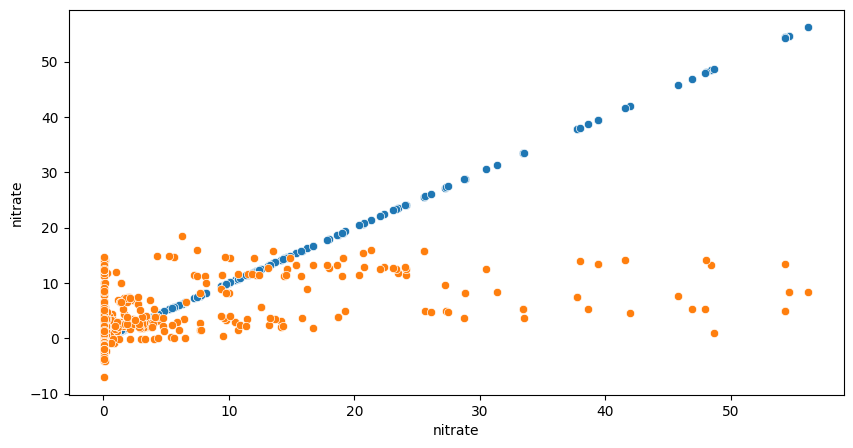

In [230]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

## Residuals

Text(0, 0.5, 'Residuals')

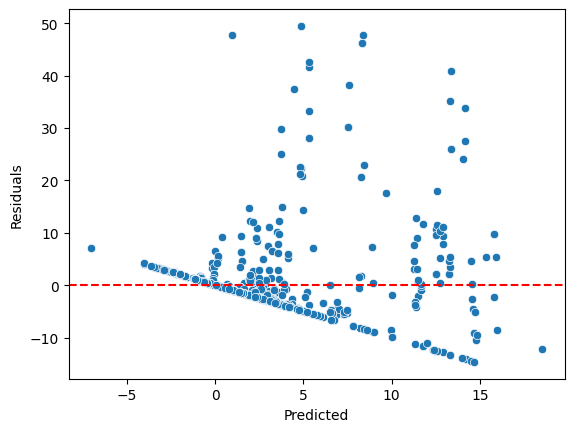

In [231]:
preds = best_model.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Predictions on the map

In [232]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

882
882
882
882


In [233]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

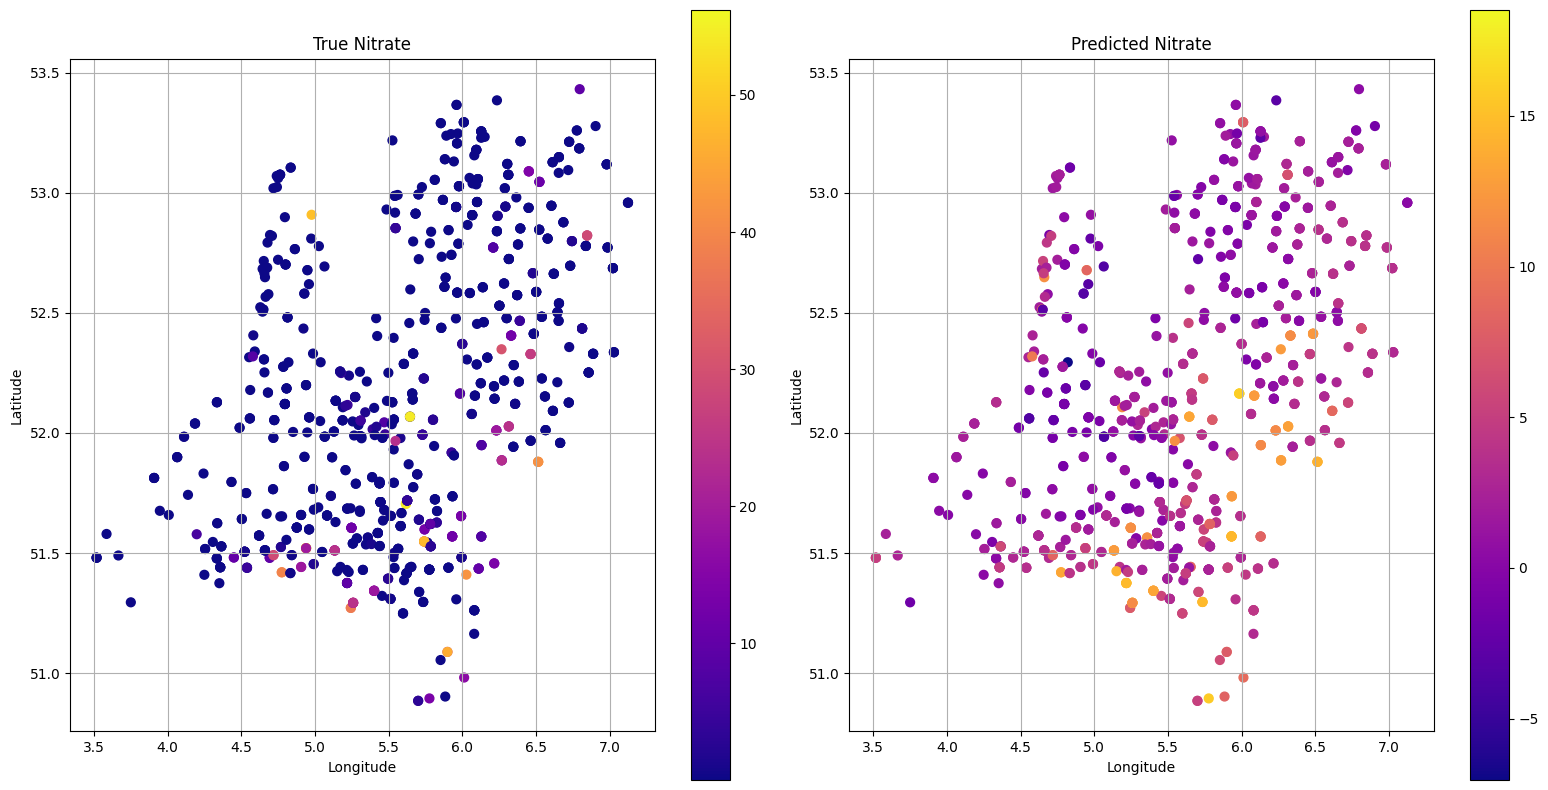

In [234]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

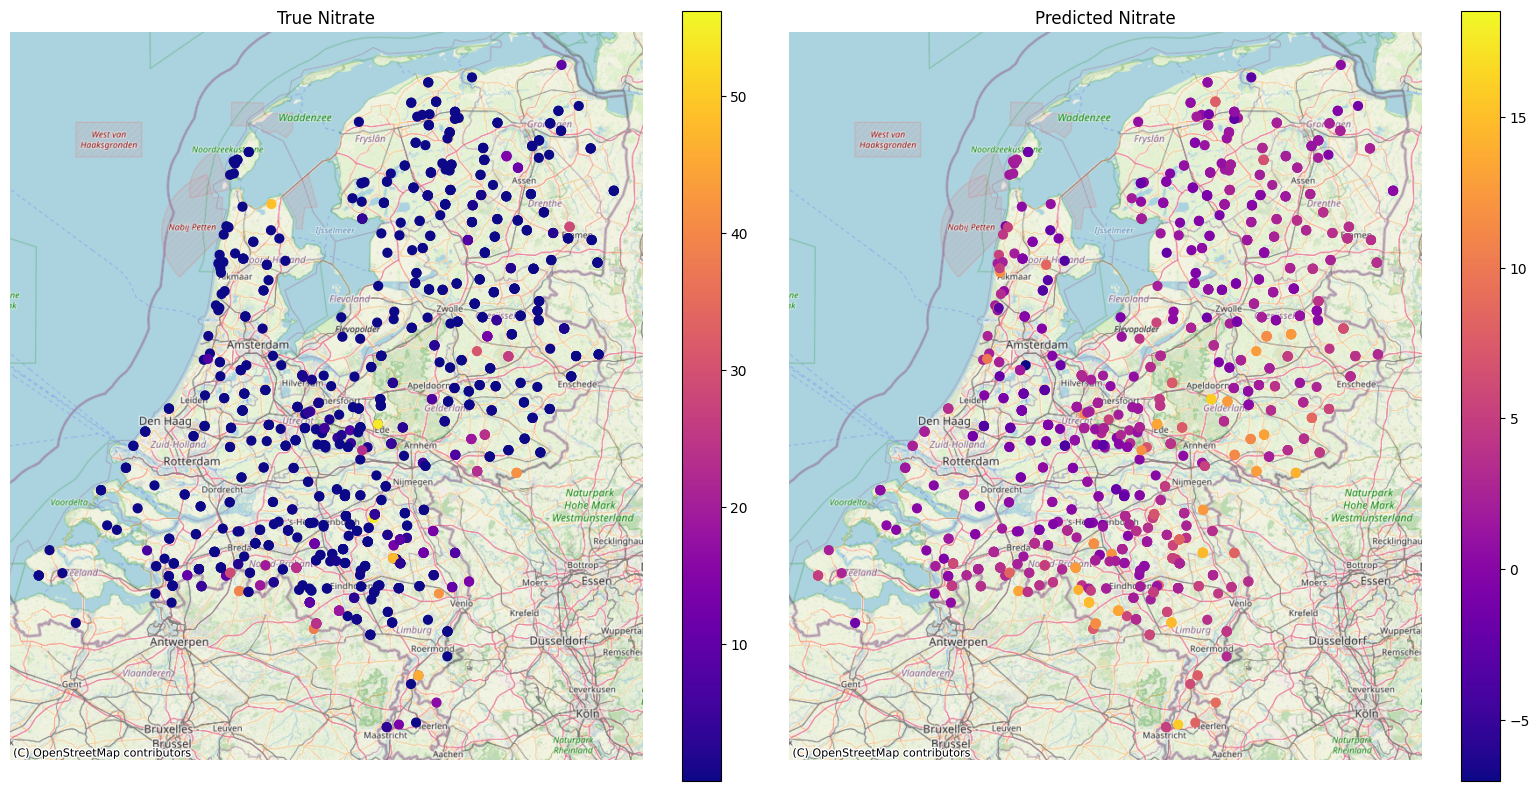

In [235]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

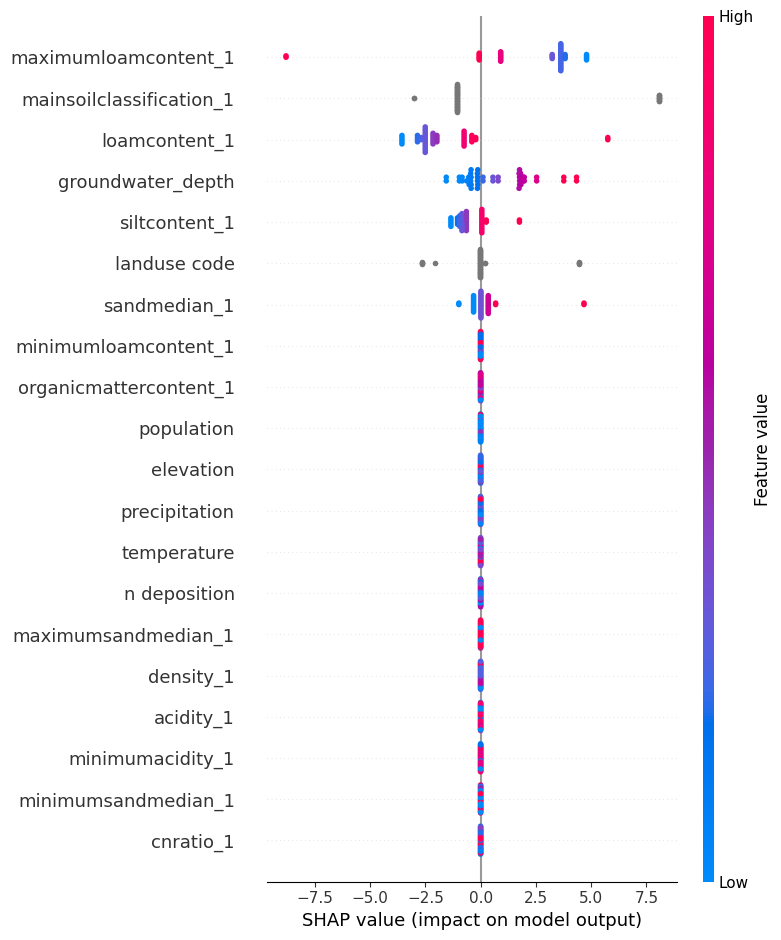

In [236]:
import shap

# Column names must match what your pipeline expects
expected_cols = X_train.columns.tolist()

# Wrapper that accepts NumPy array and returns model predictions
def wrapped_predict(X_array):
    # Convert NumPy array back to DataFrame with the correct column names
    X_df = pd.DataFrame(X_array, columns=expected_cols)
    return best_model.predict(X_df)

# Background data as DataFrame
X_background = X_train.sample(100, random_state=0)

# Create SHAP KernelExplainer with the safe wrapped function
explainer_shap = shap.KernelExplainer(wrapped_predict, X_background)

# Apply to a few test instances (keep it small to reduce compute time)
shap_values = explainer_shap.shap_values(X_test.iloc[:50])

# Plot summary
shap.summary_plot(shap_values, X_test.iloc[:50])


In [237]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=30,
    random_state=0,
    n_jobs=-1
)

# Display top features
for i in perm.importances_mean.argsort()[::-1][:20]:
    print(f"{X_test.columns[i]}: {perm.importances_mean[i]:.4f} ± {perm.importances_std[i]:.4f}")


maximumloamcontent_1: 0.8005 ± 0.0409
loamcontent_1: 0.5369 ± 0.0322
mainsoilclassification_1: 0.2127 ± 0.0231
groundwater_depth: 0.0751 ± 0.0091
landuse code: 0.0495 ± 0.0088
siltcontent_1: 0.0466 ± 0.0082
sandmedian_1: 0.0372 ± 0.0084
organicmattercontent_1: 0.0000 ± 0.0000
population: 0.0000 ± 0.0000
elevation: 0.0000 ± 0.0000
precipitation: 0.0000 ± 0.0000
temperature: 0.0000 ± 0.0000
n deposition: 0.0000 ± 0.0000
maximumsandmedian_1: 0.0000 ± 0.0000
density_1: 0.0000 ± 0.0000
minimumloamcontent_1: 0.0000 ± 0.0000
acidity_1: 0.0000 ± 0.0000
minimumacidity_1: 0.0000 ± 0.0000
cnratio_1: 0.0000 ± 0.0000
calciccontent_1: 0.0000 ± 0.0000
